In [38]:
# DATA PROCESSING HELPERS 
import numpy as np 
import pandas as pd
import os

def mask_first(x):
    result = np.ones_like(x)
    result[0] = 0
    return result
   
def train_test_split(df):
    df_test = df.copy(deep=True)
    df_train = df.copy(deep=True)

    # Group by user_id and select only the first item for each user (our holdout).
    df_test = df_test.groupby(['user_id']).first()
    df_test['user_id'] = df_test.index
    df_test = df_test[['user_id', 'artist_id', 'plays']]

    # Remove the same items as we for our test set in our training set.
    mask = df.groupby(['user_id'])['user_id'].transform(mask_first).astype(bool)
    df_train = df.loc[mask]

    return df_train, df_test

def load_dataset(working_dir):

    df = pd.read_csv(working_dir + '/SPOTIFY_DATA/spotify_dataset.csv', on_bad_lines='skip') 
    df.columns = ['user_id', 'artist', 'track', 'playlist'] 
    df = df[['user_id', 'artist', 'track']]
    df = df.dropna().drop_duplicates() # to get rid of potential (artist, song) appearing in multiple playlists of user 

    # create interaction column, by counting number of unique songs a user likes of the artist
    interactions = df.groupby(['user_id', 'artist'])['track'].count().reset_index().rename(columns={'track':'plays'})
    df = df.merge(interactions, on = ['user_id', 'artist'], how = 'inner')[['user_id', 'artist', 'plays']]
    
    artists_per_user = df.groupby(by=["user_id"])['artist'].unique().reset_index().rename(columns={'artist':'unique_artists'})
    artists_per_user['consumed_item_count'] = [len(x) for x in artists_per_user['unique_artists'] ]
    artists_per_user = artists_per_user.query("consumed_item_count > 5")
    valid_users = artists_per_user['user_id'].unique()
#     df = df.query("user_id in @valid_users")
    
    
     # Create a numeric user_id and artist_id column
    df['user_id'] = df['user_id'].astype("category").cat.codes
    df['artist_id'] = df['artist'].astype("category").cat.codes
    df = df.drop_duplicates().reset_index()

    # Create a lookup frame to get artist names back in readable form later.
    item_lookup = df[['artist_id', 'artist']].drop_duplicates()
    item_lookup['artist_id'] = item_lookup.artist_id.astype(int)

    # Grab the columns we need in the order we need them.
    df = df[['user_id', 'artist_id', 'plays']]

    # Create training and test sets.
    df_train, df_test = train_test_split(df)

    # Create lists of all unique users and artists
    users = list(np.sort(df.user_id.unique()))
    items = list(np.sort(df.artist_id.unique()))

    # Get all user ids and item ids.
    uids = np.array(df_train.user_id.astype(int).tolist())
    iids = np.array(df_train.artist_id.astype(int).tolist())

    return uids, iids, df_train, df_test, users, items, item_lookup, df


def get_train_instances(uids, iids, num_neg, items):
    """  Returns:
          user_input : A list containing the records' user_id
          item_input : A list containing the records' artist_id
          labels     : A list of labels. 0 indicating that the user has not consumed the item (negative) 
                                       1 indicating that the user has  consumed the item (positive) 
    """
    user_input, item_input, labels = [],[],[]
    zipped = set(zip(uids, iids))
    
    for (u, i) in zip(uids,iids):
        # Add  positive interaction
        user_input.append(u)
        item_input.append(i)
        labels.append(1)
    
        # Sample a number of random negative interactions
        for t in range(num_neg):
            j = np.random.randint(len(items))
            while (u, j) in zipped:
                j = np.random.randint(len(items))
            user_input.append(u)
            item_input.append(j)
            labels.append(0)
    
    return user_input, item_input, labels

def get_holdout_item(user_lookup_id, df_test, item_lookup):
    holdout_item = df_test.query("user_id == @user_lookup_id")
    return holdout_item.merge(item_lookup, on = 'artist_id')
    

In [39]:
# MODEL UTILITIES 
from tensorflow.keras.layers import Dense, Embedding, Flatten, Input, Concatenate, Multiply, Dropout
# from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import Model
from keras.optimizers import Adam
from keras.regularizers import l2
import pandas as pd 
import numpy as np 
from keras.utils.vis_utils import plot_model


def create_NCF(users, items, latent_features, learning_rate = 0.001, dense_layers=[64, 32, 16, 8], reg_layers=[0, 0, 0, 0], reg_mf=0, emb_initializer='RandomNormal'):
    
    #input layer 
    user_input = Input(shape = (1,), name='user_input' )
    item_input = Input(shape = (1,), name='item_input' )

    #embeddings 
    MF_user = Embedding(input_dim = len(users), output_dim = latent_features,
                        embeddings_regularizer = l2(reg_mf), input_length=1, embeddings_initializer = emb_initializer) 
    MF_item = Embedding(input_dim = len(items), output_dim = latent_features,
                        embeddings_regularizer = l2(reg_mf), input_length=1, embeddings_initializer = emb_initializer)
    
    MLP_user = Embedding(input_dim = len(users), output_dim = int(dense_layers[0]/2), 
                         embeddings_regularizer = l2(reg_mf), input_length=1, embeddings_initializer = emb_initializer)
    MLP_item = Embedding(input_dim = len(items), output_dim = int(dense_layers[0]/2), 
                         embeddings_regularizer = l2(reg_mf), input_length=1, embeddings_initializer = emb_initializer)
    
    # flatten and mulitply/concatenate
    MF_user_latent = Flatten()(MF_user(user_input))
    MF_item_latent = Flatten()(MF_item(item_input))
    MF_latent = Multiply() ([ MF_user_latent, MF_item_latent ])
    
    MLP_user_latent = Flatten()(MLP_user(user_input))
    MLP_item_latent = Flatten()(MLP_item(item_input))
    MLP_latent = Concatenate() ([ MLP_user_latent, MLP_item_latent ])

    mlp_vector = MLP_latent
    for i in range(1,len(dense_layers)):
        layer = Dense(dense_layers[i], activation='relu',name='layer%d' % i, 
                      kernel_regularizer=l2(reg_layers[i]))
        mlp_vector = layer(mlp_vector)
    
    # dropout = Dropout(0.25)(mlp_vector)
    predict_layer = Concatenate()([MF_latent, mlp_vector])
    result = Dense(1, activation='sigmoid', kernel_initializer='lecun_uniform', name='result')
    
    model = Model(inputs=[user_input,item_input], outputs=result(predict_layer))
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

def model_predict(model, user_lookup_id, items, item_lookup, items_pred, get_item_name = False):
    users_pred = np.full(len(items), user_lookup_id, dtype='int32')
    # items_pred = np.array(items, dtype='int32')
    predictions = pd.DataFrame(model.predict([users_pred,items_pred],batch_size=3000, verbose=0)).reset_index()
    predictions.columns = ['item_id', 'probability']
    #.sort_values(by='0', ascending=False).reset_index()
    if(get_item_name):
        predictions = predictions.merge(item_lookup, right_on='artist_id', left_on='item_id', how = 'left')
    return predictions


def visualize_model(model):
    model.summary()
    plot_model(model)

In [40]:
import numpy as np 
import pandas as pd 
from tqdm import tqdm

def user_has_consumed(df, user_lookup_id, item_lookup):
    user_data = df.query(" user_id == @user_lookup_id ")
    user_data = user_data.merge(item_lookup, on = ['artist_id'], how = 'left')
    return user_data

def get_metrics(recommendations, df_train, df_test, user_lookup_id, item_lookup, k=10):
    # retrieve holdout item
    hold_out = df_test.query("user_id == @user_lookup_id")["artist_id"].values[0]

    # get all items the user consumed AND that the model was trained on 
    train_consumed = user_has_consumed(df_train, user_lookup_id, item_lookup)

    # filter out the recommended items which the user already consumed 
    recommendations = recommendations.query("item_id not in @train_consumed").sort_values(by='probability', ascending=False).reset_index()
    
    # get index of holdout item (recommendation position)
    holdouts_index = recommendations.index[recommendations['item_id']==hold_out]

    return holdouts_index[0], recommendations.loc[holdouts_index[0]]['probability']


def evaluate_hit_rates(model, df_train, df_test, items, item_lookup, items_pred, enrich_df, enrich = True, records = 160000):
    count = 0
    holdout_index_arr, holdout_probability= [],[]
    for user_lookup_id in tqdm(df_train.user_id.unique()):
        # 1st create recommendations 
        recommendations = model_predict(model, user_lookup_id, items, item_lookup, items_pred, False) 
        # 2nd get_metrics
        holdout_index, holdout_prob = get_metrics(recommendations, df_train, df_test, user_lookup_id, item_lookup)
        # 3rd record hit_rate + index of occurance 
        holdout_index_arr.append(holdout_index)
        holdout_probability.append(holdout_prob)
        count += 1
        if(count > records):
            break
    sys_performance = pd.DataFrame.from_dict({"user_id" : df_train.user_id.unique()[:(records + 1)], 
                                   "reccomended_rank" : holdout_index_arr, 
                                   "reccomendation_prob" : holdout_probability})
    if(enrich):
        sys_performance = sys_performance.merge(enrich_df, how = 'left', on = 'user_id')
        sys_performance['correctly_labeled'] =  [0 if x <=0.5 else 1 for x in sys_performance.reccomendation_prob]
        
    return sys_performance



In [46]:
#__________________________________________NeuMF MODEL_________________________________________

epochs = 25
batch_size = 10000
learning_rate = 0.01
bs_2_lr = batch_size / learning_rate

model_8 = create_NCF(users, items, latent_features=12, learning_rate = learning_rate, dense_layers=[128, 64, 32, 16], reg_layers=[0.05, 0.05, 0.05, 0.0, 0.0], reg_mf=0)
print(model_8.summary())
hist_8 = model_8.fit( X, y , batch_size=batch_size, epochs=epochs, verbose=1, shuffle=True, validation_data = [X_test, y_test])


Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 user_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 item_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 embedding_22 (Embedding)       (None, 1, 64)        1018496     ['user_input[0][0]']             
                                                                                                  
 embedding_23 (Embedding)       (None, 1, 64)        18548224    ['item_input[0][0]']             
                                                                                            

TESTING  Loss: 0.9111763834953308  Accuracy: 0.842591404914856


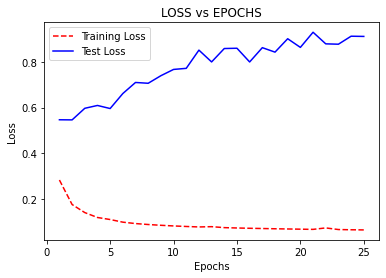

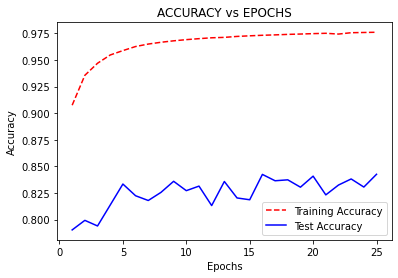

In [49]:
#__________________________________________EXPLORATORY DATA ANALYSIS_________________________________________
import matplotlib.pyplot as plt 

print("TESTING  Loss: {0}  Accuracy: {1}".format(*model_8.evaluate(X_test, y_test, verbose=0)))

training_loss = hist_8.history['loss']
test_loss = hist_8.history['val_loss']

training_acc = hist_8.history['accuracy']
test_acc = hist_8.history['val_accuracy']

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

# Visualize loss history
plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, test_loss, 'b-')
plt.legend(['Training Loss', 'Test Loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('LOSS vs EPOCHS')
plt.show();

# Visualize accuracy history
plt.plot(epoch_count, training_acc, 'r--')
plt.plot(epoch_count, test_acc, 'b-')
plt.legend(['Training Accuracy', 'Test Accuracy'])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('ACCURACY vs EPOCHS')
plt.show();


In [50]:
#__________________________________________MODEL EVALUATION_________________________________________

sys_metrics_8 = evaluate_hit_rates(model_8, df_train, df_test, items, item_lookup, items_pred, enrich_df)
print("Average Probability: ", np.mean(sys_metrics_8.reccomendation_prob))
print("Accuracy Classification: ", np.mean(sys_metrics_8.correctly_labeled))


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 15351/15351 [1:44:01<00:00,  2.46it/s]

Average Probability:  0.838995568362053
Accuracy Classification:  0.8579897075109113


94542
   user_id  artist_id  plays      artist
0        6      94542      1  Gang Starr
       item_id  probability  artist_id      artist
94542    94542     0.714252      94542  Gang Starr
         bins  correctly_labeled
0     [0, 25)           0.832446
1    [25, 50)           0.864478
2    [50, 75)           0.879786
3   [75, 100)           0.875322
4  [100, 150)           0.865922
5  [150, 200)           0.857580
6  [200, 250)           0.869081
7  [250, 300)           0.857317
8  [300, 350)           0.856220
9  [350, 500)           0.847666


/var/folders/rl/fpvhf6bs79z4s6w15f_rjkq00000gn/T/ipykernel_88005/2105130722.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sys_metrics_small['bins'] = pd.cut(sys_metrics_8["#_items_consumed"], [0,25,50,75,100, 150, 200, 250, 300, 350, 500], include_lowest=True,right = False)


(0.0, 5000.0)

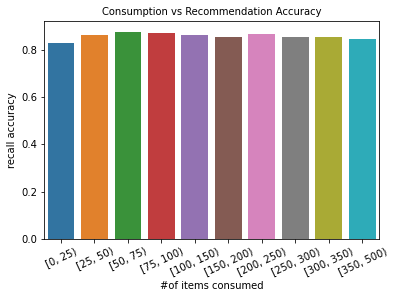

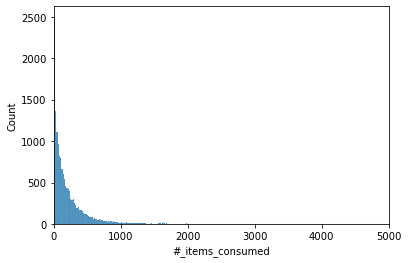

In [56]:
import seaborn as sns 

user_lookup_id = 6
holdout_item = get_holdout_item(user_lookup_id, df_test, item_lookup).artist_id[0]
print(holdout_item)
consumed_df = user_has_consumed(df, user_lookup_id, item_lookup)
print(consumed_df)

predictions = model_predict(model_8, user_lookup_id, items, item_lookup, items_pred, get_item_name = True )
prediction_holdout = predictions.query("artist_id == @holdout_item")
print(prediction_holdout)


sys_metrics_small = sys_metrics_8[sys_metrics_8["#_items_consumed"] < 500]
sys_metrics_small['bins'] = pd.cut(sys_metrics_8["#_items_consumed"], [0,25,50,75,100, 150, 200, 250, 300, 350, 500], include_lowest=True,right = False)
consumption_vs_accuracy = sys_metrics_small.groupby(["bins"])["correctly_labeled"].mean().reset_index()
print(consumption_vs_accuracy)

plt.figure()
sns.barplot(x = consumption_vs_accuracy["bins"],  y = consumption_vs_accuracy["correctly_labeled"])
plt.xlabel('#of items consumed')
plt.ylabel('recall accuracy')
plt.xticks(fontsize=10, rotation=25)
plt.title('Consumption vs Recommendation Accuracy', fontsize=10)

plt.figure()
sns.histplot(sys_metrics_8['#_items_consumed'])
plt.xlim(0, 5000)

